note: you cannot process srad on it's own. you must process any other variable first. this is because the srad values written to the pxv files span over the fill value used (-9999). so we need to create a mask from a different variable in order to correctly identify which srad grids should be scaled and which are masked grids.

In [1]:
import numpy as np
from calendar import isleap
import xarray as xr
import dask.array as da
import dask
import rioxarray as rio
import pandas as pd
import os

In [2]:
# client.shutdown()

In [3]:
# print('importing...')
# from dask.distributed import Client,LocalCluster

# print('starting client...')
# nworkers=20
# cluster=LocalCluster(n_workers=nworkers,threads_per_worker=1)#, memory_limit="4.5GiB") # a cluster where each thread is a separate process or "worker"
# client=Client(cluster)  # connect to your compute cluster
# client.wait_for_workers(n_workers=nworkers,timeout=10) # wait up to 10s for the cluster to be fully ready, error if not ready in 10s
# client

In [4]:
# things we need to know up front from Gunther

# 1) global grid ny,nx including Antarctia. this is the shape of the ALOS mask
ny_global=2160
nx_global=4320

# 2) global grid ny,nx excluding Antarctica. ny corresponds to IRmax in Gunther's fortran program
ny=1800
nx=nx_global

# 3) data type of what's inside the pxv files (2 byte int = python np.int16)
dtype_d=np.int16   # 2 byte integers for daily data
dtype_m=np.float32 # 4 byte floats for monthly data

# 4) fill value used in the pxv files
fillval_d=-9999   # daily
fillval_m=-9999.0 # monthly

# 5) total number of data points in the pxv files including points set to the fillval
npts=2295358

# 6) total number of data points in the pxv files with valid data values
# this is so we can identify which points should be masked and which shouldn't when the data range spans over the fillval
# which is a problem for srad
npts_valid_d=2287408  # daily files
npts_valid_m=2268708  # monthly files

# 7) scale factors for putting the data in the pxv files units in the table below
# in alphabetical order by variable name 
scale_factors=[0.0001,1000.,0.01,0.01,0.01,0.001]

# Variable	Monthly data	Daily deviations/distr.	Scale factor
# Precip	     mm/day	         %_of_month×100	       0.0001
# Srad	       J/m2/day	            kJ/m2/day	        1000.
# Tmax	         °C	                 °C×100	            0.01
# Tmin	         °C	                 °C×100	            0.01
# Vapr	         hPa	                Pa	            0.01
# Wind	        m/sec	              mm/sec	        0.001

In [5]:
# other constants 

# pxv things
pxv_basedir='/work/hpc/datasets/un_fao/gaez_v5/clim/AgERA5/Hist/'
dataset='AgERA5'
experiment='Hist'
pxvsuf='_5m.pxv'
connector='_'
dailytag='365'
sep='/'
pxvdirnames=['prec','srad','tmax','tmin','vapr','wind']
varnames=['Precip','Srad','Tmax-2m','Tmin-2m','Vapr','Wind-10m']

# raster things
maskfile='/work/hpc/datasets/un_fao/gaez_v5/land/ALOSmask5m_fill.rst'
ydimname='y'
xdimname='x'

# output things
out_basedir='/work/hpc/datasets/un_fao/pyaez/global_daily/'

yyyy=2020
varind=0

# First, get the mask

In [6]:
### get the mask from the rst into an array of 2 dims (x,y)
### and check the mask has the same number of data grids as the pxv data

# open the maskfile but don't include antarctica so mask has shape (y:1800,x:4320)
ds=xr.open_dataset(maskfile,engine='rasterio').isel(y=slice(0,ny)).squeeze()
del ds.coords['band']

# clean up some metadata
ds[xdimname]=ds[xdimname].astype(np.float32)
ds[ydimname]=ds[ydimname].astype(np.float32)
mask2D=ds.band_data

# # convert to 0 & 1 mask
mask2D=xr.where(mask2D>0,1,0).astype('int8')

# Translate monthly means from PXV to xarray data structures

In [7]:
pxvfile_m=pxv_basedir+pxvdirnames[varind]+sep+varnames[varind]+connector+dataset+connector+experiment+connector+str(yyyy)+pxvsuf
filename=pxvfile_m.split(sep)[-1]

nmonths=12

# read file to 1D array
# monthly files have more data in them than we need so we subset the read with count=
with open(pxvfile_m,'rb') as f:
    array1D_m=np.fromfile(f,dtype=dtype_m,count=nmonths*npts)

# limit precision here?
# decs=4
# array1D=np.trunc(array1D*10**decs)/(10**decs)

# reshape the array to (npoints,ndays)
nvals=array1D_m.shape[0]             # total number of data values
npts_flt=nvals/nmonths               # number of grid points in the file, float format
npts_int=int(nvals/nmonths)              # convert to integer

# check that number of grids found in flt and int are equivalent, if not, the file was read incorrectly
assert npts_flt*10==float(npts_int*10), f"reading pxv file {filename} with incorrect number of days: {ndays}"
# check that number of grids found in the file is the number expected, if not, coordinate with Gunther
assert npts_int==npts, f"pxv file {filename} has {npts_int} total data points, expecting {npts} total data points"
print('nvalues in pxv file',nvals)
print('nmonths in pxv file',nmonths)
print('total data points in pxv file',npts_int,'expecting',npts)

# check that number of grids found in pxv file is the same as the number of grids=1 in the mask file
npts_mask=int(mask2D.sum().data)
print('total data points in mask file', npts_mask,'expecting',npts)
assert npts_int==npts_mask, f"npts in pxv is {npts}, npts in mask is {npts_mask}"

array2D_m=array1D_m.reshape(npts,nmonths) # reshape

# find out if data value range spans across the fillvalue
# if it does, we'll need to apply an extra mask later
flag_m=True if array2D_m.min() < fillval_m else False

# check data values
print('shape of numpy data array',array2D_m.shape)
print('data min/max values',array2D_m.min(),array2D_m.max())
print('apply extra mask?',flag_m)

nvalues in pxv file 27544296
nmonths in pxv file 12
total data points in pxv file 2295358 expecting 2295358
total data points in mask file 2295358 expecting 2295358
shape of numpy data array (2295358, 12)
data min/max values -9999.0 4785.29
apply extra mask? False


In [8]:
# # make sure this numpy method reads data exactly the same as the fortran method 
# temp=open('/work/hpc/datasets/un_fao/gaez_v5_intermediate/dat/Tmax-2m_AgERA5_Hist_2020_5m.dat').read().splitlines() 
# dat=temp[1::2] # grab the lines with the data (every other line)
# data_dat=np.loadtxt(dat,dtype=dtype_m)

# decs=3
# data_dat=np.trunc(data_dat*10**decs)/(10**decs)
# array1D=np.trunc(array1D*10**decs)/(10**decs)

# for p in np.arange(data_dat.shape[0]):
#     ind1=p*12
#     ind2=ind1+12
#     unique=np.unique(data_dat[p,:]-array1D[ind1:ind2])
#     assert len(unique)==1,f'not equal at index point {p}'

now we need to match each space point of the pxv data to a grid box on the mask

first we need to take each month of pxv data from 2295358 points to the full grid of 7776000 space points in 1D

then we need to reshape the 7776000 space points to 2D with shape (y:1800,x:4320)

In [9]:
mask1D=mask2D.stack(space=[ydimname,xdimname]) # collapse mask to 1D: 1800*4320 = 7776000 points
inds_data=mask1D==1  # keep track of which points are not masked out

empty1D_m=mask1D.copy().astype(dtype_m)  # placeholder array for 1D space 
empty1D_m.rio.write_nodata(fillval_m,inplace=True)
empty1D_m[:]=fillval_m

empty2D_m=mask2D.copy().astype(dtype_m)  # placeholder array for 2D grid 
empty2D_m.rio.write_nodata(fillval_m,inplace=True)
empty2D_m[:,:]=fillval_m

In [10]:
# function to call with dask delayed
def data_to_nd_array(i,inds,arr1D,pxv,arr2D):
    arr1D[inds]=pxv.squeeze()  # remove singleton dim (day)
    arr2D[:,:]=arr1D.unstack() # put 1D data onto the 2D grid
    return arr2D.copy()

In [11]:
%%time
# dask parallel computing 

# first convert to pxv data to chunked dask array, 1 day per chunk 
# and save to list of delayed dask objects
pxv_delay=da.from_array(array2D_m,chunks=(-1,1)).to_delayed().ravel() 

# build a list a computational tasks to be executed later
task_list=[dask.delayed(data_to_nd_array)(imonth,inds_data,empty1D_m,pxvdata,empty2D_m) for imonth,pxvdata in enumerate(pxv_delay)] 
assert len(task_list)==nmonths, f'{len(task_list)} tasks in list, should be {nmonths}' # double check we've got 1 task per day of data

# execute all computations
print('putting 1D data on a 2D grid...')
result_chunks_m=dask.compute(*task_list)

# concatenate the resulting daily chunks along a new time dimension
print('concatenating...')
data3D_m=xr.concat(result_chunks_m,dim='time')

# replace fillval with nan
print('adding nans...')
data3D_m=xr.where(data3D_m==fillval_m,np.nan,data3D_m)

# check we have the correct number of non-missing data points
data_mask_m=xr.where(np.isnan(data3D_m.data),0,1)  
ngrids_data_m=int(data_mask_m.sum()/data_mask_m.shape[0])
print('total number of non-missing data points',ngrids_data_m,'expecting',npts_valid_m)
assert ngrids_data_m==npts_valid_m, f'data mask creation issue. found {ngrids_data_m} valid data points (non missing), expecting {npts_valid_m}' # double check we've got 1 task per day of data

putting 1D data on a 2D grid...
concatenating...
adding nans...
total number of non-missing data points 2268708 expecting 2268708
CPU times: user 3.54 s, sys: 1.05 s, total: 4.59 s
Wall time: 4.09 s


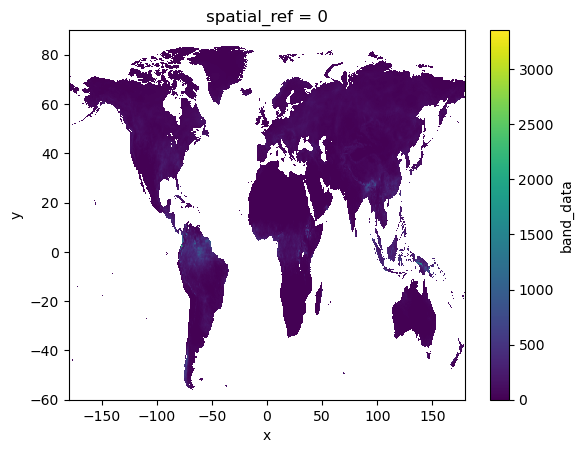

In [12]:
# visual check January
data3D_m.isel(time=0).plot()

# Translate daily deviations from PXV to scaled xarray data structures

In [13]:
### get the data from the pxv into an array of 2 dims (space,time)
pxvfile=pxv_basedir+pxvdirnames[varind]+sep+varnames[varind]+dailytag+connector+dataset+connector+experiment+connector+str(yyyy)+pxvsuf
filename=pxvfile.split(sep)[-1]

# read entire file into 1D array
with open(pxvfile,'rb') as f:
    array1D_d=np.fromfile(f,dtype=dtype_d)
    
# reshape the array to (npoints,ndays)
nvals=array1D_d.shape[0]             # total number of data values
ndays=366 if isleap(yyyy) else 365 # number of days of data at each grid point
npts_flt=nvals/ndays               # number of grid points in the file, float format
npts_int=int(nvals/ndays)              # convert to integer

# check that number of grids found in flt and int are equivalent, if not, the file was read incorrectly
assert npts_flt*10==float(npts_int*10), f"reading pxv file {filename} with incorrect number of days: {ndays}"
# check that number of grids found in the file is the number expected, if not, coordinate with Gunther
assert npts_int==npts, f"pxv file {filename} has {npts_int} total data points, expecting {npts} total data points"
print('nvalues in pxv file',nvals)
print('ndays in pxv file',ndays)
print('total data points in pxv file',npts_int,'expecting',npts)

# check that number of grids found in pxv file is the same as the number of grids=1 in the mask file
npts_mask=int(mask2D.sum().data)
print('total data points in mask file', npts_mask,'expecting',npts)
assert npts_int==npts_mask, f"npts in pxv is {npts}, npts in mask is {npts_mask}"

array2D_d=array1D_d.reshape(npts,ndays) # reshape

# find out if data value range spans across the fillvalue
# if it does, we'll need to apply an extra mask later
flag_d=True if array2D_d.min() < fillval_d else False

# check data values
print('shape of numpy data array',array2D_d.shape)
print('data min/max values',array2D_d.min(),array2D_d.max())
print('apply extra mask?',flag_d)
# array2D[0,:]   

nvalues in pxv file 840101028
ndays in pxv file 366
total data points in pxv file 2295358 expecting 2295358
total data points in mask file 2295358 expecting 2295358
shape of numpy data array (2295358, 366)
data min/max values -9999 10000
apply extra mask? False


In [14]:
# # make sure this numpy method reads data exactly the same as the fortran method 
# temp=open('/work/hpc/datasets/un_fao/gaez_v5_intermediate/dat/Tmax-2m365_AgERA5_Hist_2020_5m.dat').read().splitlines() 
# dat=temp[1::2] # grab the lines with the data (every other line)
# data_dat=np.loadtxt(dat,dtype='int16')
# for p in np.arange(array2D.shape[0]):
#     unique=np.unique(data_dat[p,:]-array2D[p,:])
#     assert len(unique)==1,f'not equal at index point {p}'

now we need to match each space point of the pxv data to a grid box on the mask

first we need to take each day of pxv data from 2295358 points to the full grid of 7776000 space points in 1D

then we need to reshape the 7776000 space points to 2D with shape (y:1800,x:4320)

In [15]:
mask1D=mask2D.stack(space=[ydimname,xdimname]) # collapse mask to 1D: 1800*4320 = 7776000 points
inds_data=mask1D==1  # keep track of which points are not masked out

empty1D_d=mask1D.copy().astype(dtype_d)  # placeholder array for 1D space 
empty1D_d.rio.write_nodata(fillval_d,inplace=True)
empty1D_d[:]=fillval_d

empty2D_d=mask2D.copy().astype(dtype_d)  # placeholder array for 2D grid 
empty2D_d.rio.write_nodata(fillval_d,inplace=True)
empty2D_d[:,:]=fillval_d

In [16]:
# function to call with dask delayed
def data_to_nd_array(i,inds,arr1D,pxv,arr2D):
    arr1D[inds]=pxv.squeeze()  # remove singleton dim (day)
    arr2D[:,:]=arr1D.unstack() # put 1D data onto the 2D grid
    return arr2D.copy()

In [17]:
%%time
# dask parallel computing 

# first convert to pxv data to chunked dask array, 1 day per chunk 
# and save to list of delayed dask objects
pxv_delay=da.from_array(array2D_d,chunks=(-1,1)).to_delayed().ravel() 

# build a list a computational tasks to be executed later
task_list=[dask.delayed(data_to_nd_array)(iday,inds_data,empty1D_d,pxvdata,empty2D_d) for iday,pxvdata in enumerate(pxv_delay)] 
assert len(task_list)==ndays, f'{len(task_list)} tasks in list, should be {ndays}' # double check we've got 1 task per day of data

# execute all computations
print('putting 1D data on a 2D grid...')
result_chunks_d=dask.compute(*task_list)

# concatenate the resulting daily chunks along a new time dimension
print('concatenating...')
data3D_d=xr.concat(result_chunks_d,dim='time')

putting 1D data on a 2D grid...


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


concatenating...
CPU times: user 1min 44s, sys: 21.3 s, total: 2min 6s
Wall time: 19.7 s


In [18]:
%%time
# change out the fill value to nans
# this is where we need to apply an extra mask if the valid range of the data includes the -9999 fillval
# which is the case for srad ************ADD OTHERS HERE************************

print('changing dtype...')
data3D_d=data3D_d.astype(np.float32)

# if valid data range includes fillval
if flag_d:
    print('processing pxv variable with data values that span over the fillval')
    print('scaling...')
    data3D_d=data3D_d*scale_factors[varind]    
    print('applying additional mask...')
    data3D_d=xr.where(data_mask,data3D_d,np.nan)
    # verify that the masking worked
    valid_arr=np.where(np.isnan(data3D_d.data[15,:,:]),0,1) # pick one day to verify  
    nvalid=valid_arr.sum()
    print('total number of non-missing data points',nvalid,'expecting',npts_valid_d)
    assert nvalid==npts_valid_d, f'data mask application issue. found {nvalid} valid data points (non missing), expecting {npts_valid_d}'    

# if valid data range doesn't include fillval
else:
    print('adding nans...')
    data3D_d=xr.where(data3D_d==fillval_d,np.nan,data3D_d)
    print('scaling...')
    data3D_d=data3D_d*scale_factors[varind]

    if varnames[varind] =='Precip':
        print('computing additional mask...')
        data_mask=xr.where(np.isnan(data3D_d.data),0,1)  
        ngrids_data_d=int(data_mask.sum()/data_mask.shape[0])
        print('total number of non-missing data points',ngrids_data_d,'expecting',npts_valid_d)
        assert ngrids_data_d==npts_valid_d, f'data mask creation issue. found {ngrids_data_d} valid data points (non missing), expecting {npts_valid_d}' # double check we've got 1 task per day of data

changing dtype...
adding nans...
scaling...
computing additional mask...
total number of non-missing data points 2287408 expecting 2287408
CPU times: user 11.1 s, sys: 12 s, total: 23.2 s
Wall time: 23.2 s


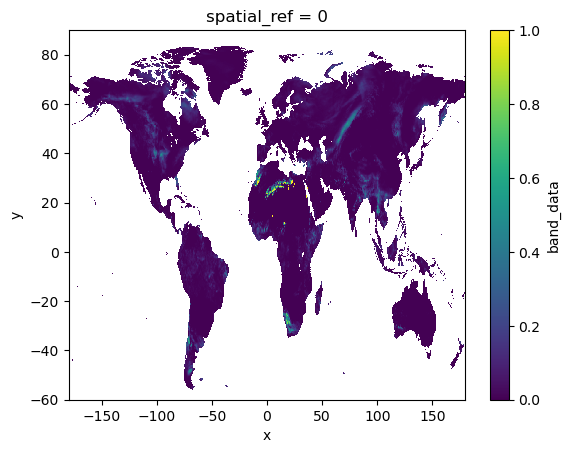

In [19]:
data3D_d.isel(time=15).plot()

# Create daily data from monthly means and daily deviations

In [20]:
chunks={'time':-1,'y':450,'x':2160}
# chunks=(-1,450,2160)

In [21]:
# create a time dimension for monthly and daily data
if (yyyy>=1980) & (yyyy<=2024):
    time_m=pd.date_range(str(yyyy)+'-01-01',str(yyyy)+'-12-31',freq='MS')
    time_d=pd.date_range(str(yyyy)+'-01-01',str(yyyy)+'-12-31',freq='D')
else:
    time_m=pd.date_range('1900-01-01','1900-12-31',freq='MS')  
    time_d=pd.date_range('1900-01-01','1900-12-31',freq='D')  

# time_m,time_d

In [22]:
# assign time metadata to monthly and daily data
data3D_m=data3D_m.assign_coords(time=("time",time_m))
data3D_d=data3D_d.assign_coords(time=("time",time_d))

In [23]:
# data3D_m

In [24]:
# var_mean=da.from_array(data3D_m,chunks=chunks)
# var_daily=da.from_array(data3D_d.data,chunks=chunks)
# var_mean=data3D_m.chunk(chunks)
# var_prime=data3D_d.chunk(chunks)
# var_mean

In [26]:
# var_prime=data3D_d
# var_mean=data3D_m



if varnames[varind]=='Precip':
    print('computing daily values for Precip')
    var_acc=data3D_m.chunk(chunks)
    var_frac=data3D_d.chunk(chunks)
    
    var_acc=var_acc.rename({'time':'month'})
    months=np.arange(12)+1
    var_acc['month']=months
    
    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        var_daily=var_frac.groupby('time.month')*var_acc  # times here instead of add
else:
    print('computing daily values for',varnames[varind])
    var_mean=data3D_m.chunk(chunks)
    var_prime=data3D_d.chunk(chunks)
    
    var_mean=var_mean.rename({'time':'month'})
    months=np.arange(12)+1
    var_mean['month']=months
        
    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        var_daily=var_prime.groupby('time.month') + var_mean
    
# var_daily

computing daily values for Precip


In [27]:
attrs={}
newvarname=varnames[varind]
if varnames[varind] == 'Srad':
    print('changing units to W/m2')
    # attrs=ds[varname].attrs
    attrs['units']='W/m2'
    
    # Convert J/m2/day to W/m2
    s_per_day=86400
    var_daily=var_daily/s_per_day
    var_daily.attrs=attrs    
    
if varnames[varind] == 'Wind-10m':
    # interp from 10m to 2m height
    print('interpolating wind to 2m')
    z=10
    z_adjust=4.87/(np.log(67.8*z-5.42))
    var_daily=var_daily*z_adjust
    
    # fix metadata
    newvarname='Wind-2m'
    attrs={'standard_name':newvarname,'long_name':'2m Wind Speed','units':'m/s'}
    # ds=ds.rename({varname:newvarname})
    var_daily.attrs=attrs    
    # varname=newvarname

In [ ]:
var_daily

In [28]:
try:
    if (yyyy>=1980) & (yyyy<=2024):
        dropdate=str(yyyy)+'-02-29'
    else: 
        dropdate='1900-02-29'
    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        data_out = var_daily.drop_sel(time=dropdate).transpose('y','x','time')#.data
    print('dropping date',dropdate)
except:
    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        data_out = var_daily.drop_sel(time=dropdate).transpose('y','x','time')#.data
data_out

dropping date 2020-02-29


<xarray.DataArray 'band_data' (y: 1800, x: 4320, time: 365)>
dask.array<transpose, shape=(1800, 4320, 365), dtype=float32, chunksize=(450, 2160, 365), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float32 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * y            (y) float32 89.96 89.88 89.79 89.71 ... -59.79 -59.88 -59.96
    spatial_ref  (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
  * time         (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-12-31
    month        (time) int64 1 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12

In [ ]:
# %%time
# data_out=data_out.compute()
# data_out

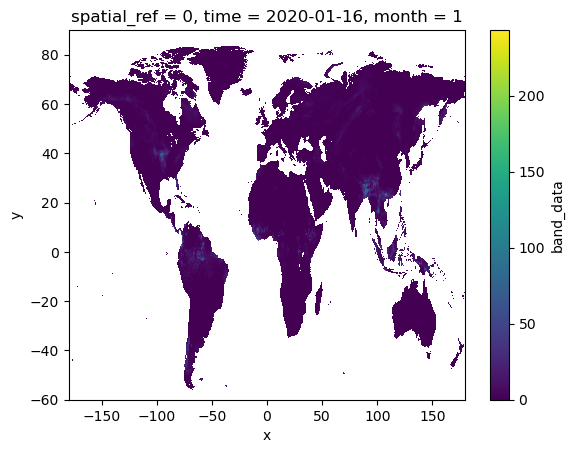

In [29]:
# import matplotlib.pyplot as plt
# plt.imshow(data_out[:,:,15],interpolation='none')
# plt.colorbar()
data_out.isel(time=15).plot()

In [30]:
np.nanmin(data_out.data).compute(),np.nanmax(data_out.data).compute()

(0.0, 588.38184)

In [31]:
%%time
out_dir=out_basedir+'testing/'+str(yyyy)+sep+newvarname+sep

# set up dir for writing npy
# out_dir=npy_dir+year+'/'+var_out+'
isExist = os.path.exists(out_dir)
if not isExist:
    os.makedirs(out_dir)
            
print('writing to',out_dir+'0.npy')     
da.to_npy_stack(out_dir,data_out.data,axis=2)    

writing to /work/hpc/datasets/un_fao/pyaez/global_daily/testing/2020/Precip/0.npy
CPU times: user 12.7 s, sys: 22.1 s, total: 34.8 s
Wall time: 23.7 s


In [32]:
# precipitation = np.load(out_dir+'0.npy')

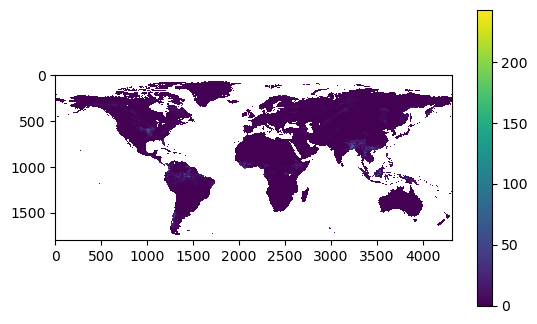

In [33]:
# import matplotlib.pyplot as plt
# plt.imshow(precipitation[:,:,15],interpolation='none')
# plt.colorbar(shrink=0.8)

In [ ]:
# function to lazy calculate daily values as daily_value = daily_deviation + monthly_mean
def calc_daily_ds(v):
    # get data 
    var_prime=xr.open_dataset(ddfile,chunks=chunks)[v] # daily devs
    var_mean=xr.open_dataset(mfile,chunks=chunks)[v] # monthly means
    
    # save variable metadata and rework for the groupby below
    varattrs=var_mean.attrs
    del varattrs['description']
    var_mean=var_mean.rename({'time':'month'})
    months=np.arange(12)+1
    var_mean['month']=months

    # lazy compute
    with dask.config.set(**{'array.slicing.split_large_chunks': False}):    
        var_daily=var_prime.groupby('time.month') + var_mean
    
    # clean up variable metadata
    var_daily=var_daily.drop('month')
    var_daily.attrs=varattrs

    # convert array to dataset and set global attributes
    ds=var_daily.to_dataset()
    ds=ds.assign_attrs({'source_data':source_data,'source_code':source_code})    
    return ds  

# function to lazy calculate daily_value = fraction_of_monthly_total * monthly_total
def calc_daily_precip_ds(v):
    # get data 
    var_frac=xr.open_dataset(ddfile,chunks=chunks)[v] # daily frac
    var_acc=xr.open_dataset(mfile,chunks=chunks)[v] # monthly acc   
    
    # save variable metadata and rework for the groupby below
    varattrs=var_acc.attrs
    del varattrs['description']
    var_acc=var_acc.rename({'time':'month'})
    months=np.arange(12)+1
    var_acc['month']=months

    # lazy compute
    with dask.config.set(**{'array.slicing.split_large_chunks': False}):        
        var_daily=var_frac.groupby('time.month')*var_acc  # times here instead of add
    
    # clean up variable metadata
    var_daily=var_daily.drop('month')
    var_daily.attrs=varattrs

    # convert array to dataset and set global attributes
    ds=var_daily.to_dataset()
    ds=ds.assign_attrs({'source_data':source_data,'source_code':source_code})
    return ds  

In [ ]:
# print('reading file')
# tds=xr.open_dataset('/work/hpc/datasets/un_fao/gaez_v5_intermediate/netcdf/Tmax-2m_Hist_DailyDev_2020_5m.nc')
# print('eliminating outlier')
# tds['Tmax-2m']=xr.where(tds['Tmax-2m']>40,np.nan,tds['Tmax-2m'])
# print('plotting')
# tds['Tmax-2m'].isel(time=0).plot()

In [ ]:
# visual check
# data3D.attrs['_FillValue']=-9999
# data3D=data3D.fillna(-9999)
data3D.isel(time=0).plot()

In [ ]:
# ds=xr.open_dataset(maskfile,engine='rasterio').isel(y=slice(0,1800)) # 1800 from Gunther
# ds

In [ ]:
mask1D=mask2D.stack(space=['y','x'])
# mask1D

In [ ]:
inds_data=mask1D==1
# inds_data

In [ ]:
mask1D_drop=mask1D[mask1D>0]
# mask_drop

In [ ]:
# newarr_drop=mask_drop.copy().astype('int16')
# newarr_drop[:]=array2D[:,0]
# newarr_drop

In [ ]:
# newarr2D=mask.copy().astype('int16')
# newarr2D[ind
newarr1D=mask1D.copy().astype('int16')#.astype('float32')
# newarr1D=xr.where(newarr1D==0,-9999,newarr1D)#np.nan,newarr1D)
newarr1D[:]=-9999
# newarr1D[inds_data]=array2D[:,0]#newarr_drop # here giving labels to the pxv data
# newarr1D

In [ ]:
# create 3D array to store data values
data2D=mask2D.copy()
# data3D=data2D.expand_dims(dim={'time':ndays},axis=2).astype('int16')#.dtype#[:]=None
# data3D[:]=-9999
# data3D

In [ ]:
# # testing
# newarr1D[:]=-9999
# newarr1D[inds_data]=array2D[:,0] 
# data3D[:,:,0]=newarr1D.unstack()

import dask.array as da

In [ ]:
array2D_da=da.from_array(array2D,chunks=(-1,1))
array2D_da

In [ ]:
# inds_da=da.from_array(inds_data
data3D_da=da.from_array(data3D,chunks=(-1,-1,1))
data3D_da

In [ ]:
def data_to_nd_array(iday,inds_data,arr1D,pdata,data_out):
    # arr1D[inds_data]=pxvdata[:,iday]
    # data_out[:,:,iday]=arr1D.unstack()
    arr1D[inds_data]=pdata.squeeze()
    data_out=data_out.squeeze()
    data_out[:,:]=arr1D.unstack()
    # data_out[:,:,iday:iday]=arr1D.unstack()
    return data_out.copy()
    

In [ ]:
import dask
# inds_delay=dask.delayed(inds_data.data.copy())
# newarr1D_delay=dask.delayed(newarr1D.data.copy())
# pxvdata_delay=dask.delayed(array2D)
pxvdata_delay=array2D_da.to_delayed().ravel() 
# data3D_delay=dask.delayed(data3D.data.copy())
data3D_delay=data3D_da.to_delayed().ravel()
# data3D_delay

In [ ]:
days=np.arange(366)
# days_da=days.from_array(days,chunks=
# len(days)

In [ ]:
zipvars=zip(days,pxvdata_delay,data3D_delay)
# for one,two,three in zipvars:
#     print(one,two,three)

In [ ]:
# tasklist=[data_to_nd_array for iday in np.arange(ndays)]
# task_list=[dask.delayed(data_to_nd_array)(iday,inds_delay,newarr1D_delay,pxvdata_delay[:,iday],data3D[:,:,iday:iday]) for iday in np.arange(ndays)] 
task_list=[dask.delayed(data_to_nd_array)(iday,inds_data,newarr1D,pxvdata,dataout) for iday,pxvdata,dataout in zipvars] 
len(task_list)

In [ ]:
result_chunks=dask.compute(*task_list)
result_chunks[0]

In [ ]:
data3D=xr.concat(result_chunks,dim='time')
data3D

In [ ]:
data3D.isel(time=0).plot()

In [ ]:
# unstack all days of 1D data onto the grid
for iday in np.arange(ndays):
    if iday%30==0: print('processing day',iday+1)
    newarr1D[:]=-9999  # wipe the 1D array
    newarr1D[inds_data]=array2D[:,iday]  # 1D pxv data to 1D labeled data
    data3D[:,:,iday]=newarr1D.unstack()  # data to 3D (lat,lon,time)
data3D    

In [ ]:
data3D=data3D.astype(np.float32)
# data3D

In [ ]:
# data3D=data3D.where(data3D!=-9999)
# data3D.dtype
data3D=xr.where(data3D==-9999,np.float32(np.nan),data3D)
data3D

In [ ]:
data3D.isel(time=0).plot()

In [ ]:
newarr2D=newarr1D.unstack() # putting pxv data on the full grid
newarr2D

In [ ]:
newarr2D=newarr2D.where(newarr2D!=-9999)
newarr2D

In [ ]:
newarr2D.plot()

In [ ]:
# mask.plot()

In [ ]:
# np.float32(mask.y[0].data),np.float32(mask.x[0].data)

In [ ]:
# # mask=mask.where(mask>0)
# mask=mask.dropna('y')
# mask=mask.dropna('x')
# mask

In [ ]:
# mask3D=mask.expand_dims(dim={'time':ndays},axis=2)
# mask3D

In [ ]:
# mask1D=mask3D.stack(space=['y','x','time'])
# mask1D

In [ ]:
test=mask.stack(space=['y','x'])
test

In [ ]:
test2D=test.expand_dims(dim={'time':ndays},axis=1)
test2D

In [ ]:
inds_data=test2D.isnull()
inds_data

In [ ]:
newarr=xr.full_like(test2D,0)
newarr

In [ ]:
newarr[inds_data==True]=array2D
newarr

In [ ]:
inds_data=test.isnull()
# inds_nodata=test[test.null()]
inds_data

In [ ]:
# mask=mask.dropna('x',how='all')
# mask
test=test.dropna('space')
test

In [ ]:
test2D=test.expand_dims(dim={'time':ndays},axis=1)
test2D

In [ ]:
newarr=xr.full_like(test2D,0)
newarr

In [ ]:
newarr[:,:]=array2D
newarr

In [ ]:
lasttest=newarr.unstack()
lasttest

In [ ]:
lasttest.isel(time=0).plot()